In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
import xgboost             as xgb
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import KFold

import random
import warnings
warnings.filterwarnings( 'ignore' )

In [181]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( (y - yhat ) / y ) )

def cross_validation( X_training, kfold, model_name, model, verbose=False ):
    
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation
        validation_start_date = X_training['date'].max() - datetime.timedelta( days=k*30*3 )
        validation_end_date = X_training['date'].max() - datetime.timedelta( days=(k-1)*30*3 )

        # filtering dataset
        training = X_training[X_training['date'] < validation_start_date]
        validation = X_training[(X_training['date'] >= validation_start_date) & (X_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales' ], axis=1 )
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold interation
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( { 'Model Name': model_name,
                            'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                            'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                            'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

**LOAD** **DATA**

In [2]:
df=pd.read_csv("/content/train 2 (2).csv")

In [3]:
df.sample()

,date,store,item,sales
165002,2014-10-25,1.0,10.0,80.0


In [4]:
df.shape

(446072, 4)

In [5]:
df.sample()

,date,store,item,sales
38057,2017-03-18,1.0,3.0,36.0


In [6]:
df.head()

,date,store,item,sales
0,2013-01-01,1.0,1.0,13.0
1,2013-01-02,1.0,1.0,11.0
2,2013-01-03,1.0,1.0,14.0
3,2013-01-04,1.0,1.0,13.0
4,2013-01-05,1.0,1.0,10.0


In [7]:
df.columns

Index(['date', 'store', 'item', 'sales'], dtype='object')

In [8]:
print( 'Number of Rows: {}'.format( df.shape[0] ) )
print( 'Number of Cols: {}'.format( df.shape[1] ) )

Number of Rows: 446072
Number of Cols: 4


**DATA** **TYPES**

In [9]:
df.dtypes

date      object
store    float64
item     float64
sales    float64
dtype: object

In [10]:
# I will use "to_date" to change to datetime.
df['date'] = pd.to_datetime( df['date']  )

In [11]:
df.dtypes

date     datetime64[ns]
store           float64
item            float64
sales           float64
dtype: object

In [12]:
df.isnull()

,date,store,item,sales
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
446067,False,False,False,False
446068,False,False,False,False
446069,False,False,False,False
446070,False,False,False,False


In [14]:
df.isnull().sum()

date     0
store    1
item     1
sales    1
dtype: int64

In [32]:
df=df.dropna()

In [33]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [34]:
df1=df.copy()


In [35]:
df1.head()

,date,store,item,sales
0,2013-01-01,1.0,1.0,13.0
1,2013-01-02,1.0,1.0,11.0
2,2013-01-03,1.0,1.0,14.0
3,2013-01-04,1.0,1.0,13.0
4,2013-01-05,1.0,1.0,10.0


In [36]:
df1.sales.value_counts()

26.0     6332
30.0     6273
31.0     6191
34.0     6191
37.0     6187
         ... 
209.0       1
199.0       1
0.0         1
210.0       1
214.0       1
Name: sales, Length: 210, dtype: int64

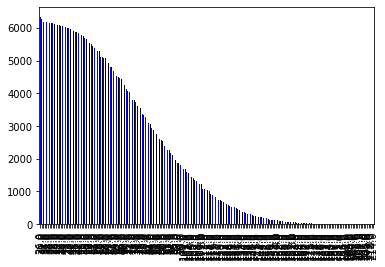

In [37]:
df1.sales.value_counts().plot(kind='bar', color=["blue", 'black'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


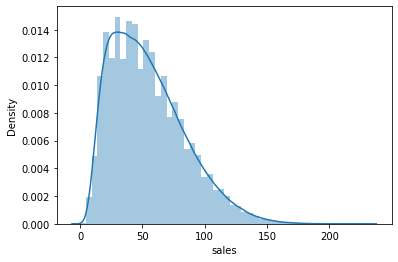

In [38]:
sns.distplot( df1['sales'] )

In [39]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446071 entries, 0 to 446070
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    446071 non-null  datetime64[ns]
 1   store   446071 non-null  float64       
 2   item    446071 non-null  float64       
 3   sales   446071 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 17.0 MB


In [40]:
df1.describe()

,store,item,sales
count,446071.000000,446071.000000,446071.000000
mean,5.450287,12.719444,54.453881
std,2.875907,7.054819,29.628029
min,1.000000,1.000000,0.000000
25%,3.000000,7.000000,31.000000
50%,5.000000,13.000000,50.000000
75%,8.000000,19.000000,73.000000
max,10.000000,25.000000,231.000000


In [41]:
df1.item.value_counts()

1.0     18260
14.0    18260
24.0    18260
23.0    18260
22.0    18260
21.0    18260
20.0    18260
19.0    18260
18.0    18260
17.0    18260
16.0    18260
15.0    18260
13.0    18260
2.0     18260
12.0    18260
11.0    18260
10.0    18260
9.0     18260
8.0     18260
7.0     18260
6.0     18260
5.0     18260
4.0     18260
3.0     18260
25.0     7831
Name: item, dtype: int64

In [42]:
pd.crosstab(df1.sales, df.item)

item,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0
sales,,,,,,,,,,,,,,,,,,,,,
0.0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.0,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.0,3,0,0,4,10,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3.0,6,0,0,13,33,0,0,0,0,0,...,2,0,0,0,0,0,0,1,0,0
4.0,23,0,0,17,60,0,0,0,0,0,...,9,2,0,0,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208.0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
209.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
210.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


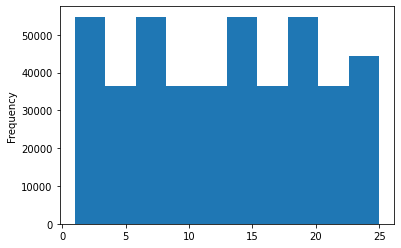

In [43]:
df1.item.plot.hist()

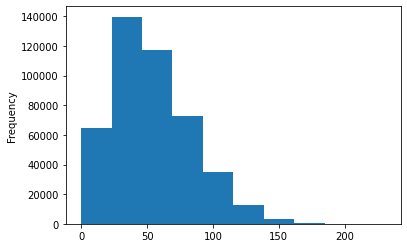

In [44]:
df1.sales.plot.hist()

 **Feature** **Engineering**

In [45]:
df2 = df1.copy()

In [46]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# day of week
df2['day_of_week'] = df2['date'].dt.dayofweek

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [47]:
df2.sample(5).T

,298298,329785,167251,381171,367066
date,2014-10-23 00:00:00,2016-01-11 00:00:00,2015-12-22 00:00:00,2016-09-25 00:00:00,2013-02-10 00:00:00
store,4.0,1.0,2.0,9.0,2.0
item,17.0,19.0,10.0,21.0,21.0
sales,35.0,22.0,65.0,49.0,36.0
year,2014,2016,2015,2016,2013
month,10,1,12,9,2
day,23,11,22,25,10
day_of_week,3,0,1,6,6
week_of_year,43,2,52,38,6
year_week,2014-42,2016-02,2015-51,2016-38,2013-05


In [48]:
df3 = df2.copy()
df3.head()

,date,store,item,sales,year,month,day,day_of_week,week_of_year,year_week
0,2013-01-01,1.0,1.0,13.0,2013,1,1,1,1,2013-00
1,2013-01-02,1.0,1.0,11.0,2013,1,2,2,1,2013-00
2,2013-01-03,1.0,1.0,14.0,2013,1,3,3,1,2013-00
3,2013-01-04,1.0,1.0,13.0,2013,1,4,4,1,2013-00
4,2013-01-05,1.0,1.0,10.0,2013,1,5,5,1,2013-00


In [49]:
df3 = df3[df3['sales'] > 0] # here we have removed the 0 sales items because they are not relevent

**Response** **Variable**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


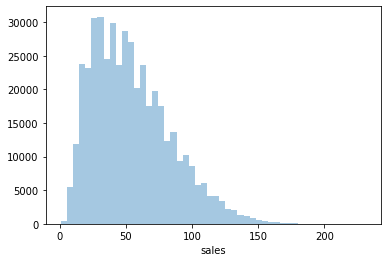

In [50]:
sns.distplot( df3['sales'], kde=False )

**Bivariate** **Analysis**

**Stores selling more items over the years.**

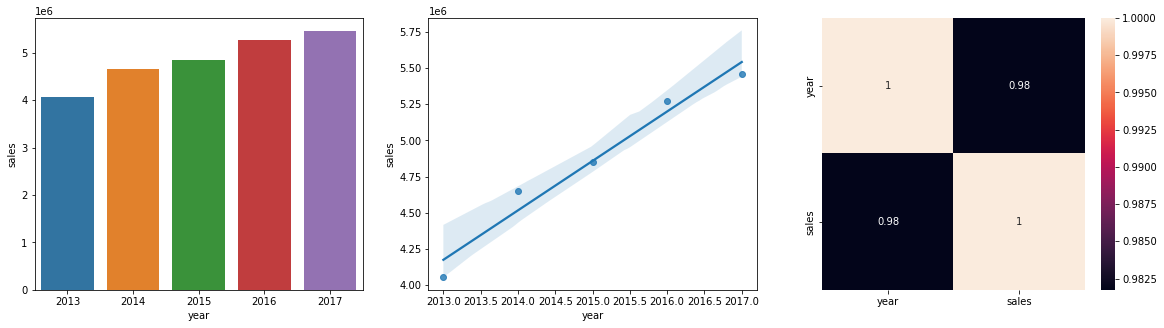

In [51]:
# As we only have information on sales dates in this dataset, I will use only the time hypothesis ..


plt.figure(figsize=(20,5)) 
aux1 = df3[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

**Stores sell more items in the second half of the year.**

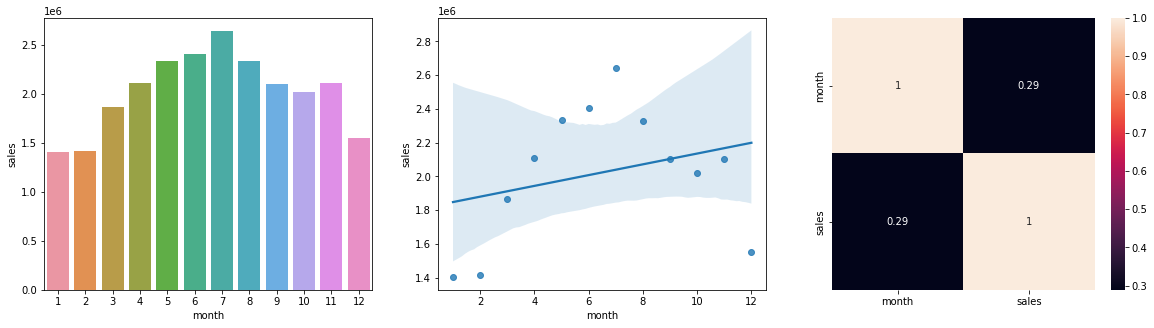

In [52]:
plt.figure(figsize=(20,5)) 
aux1 = df3[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

**Stores sell more items after the 10th of each month**

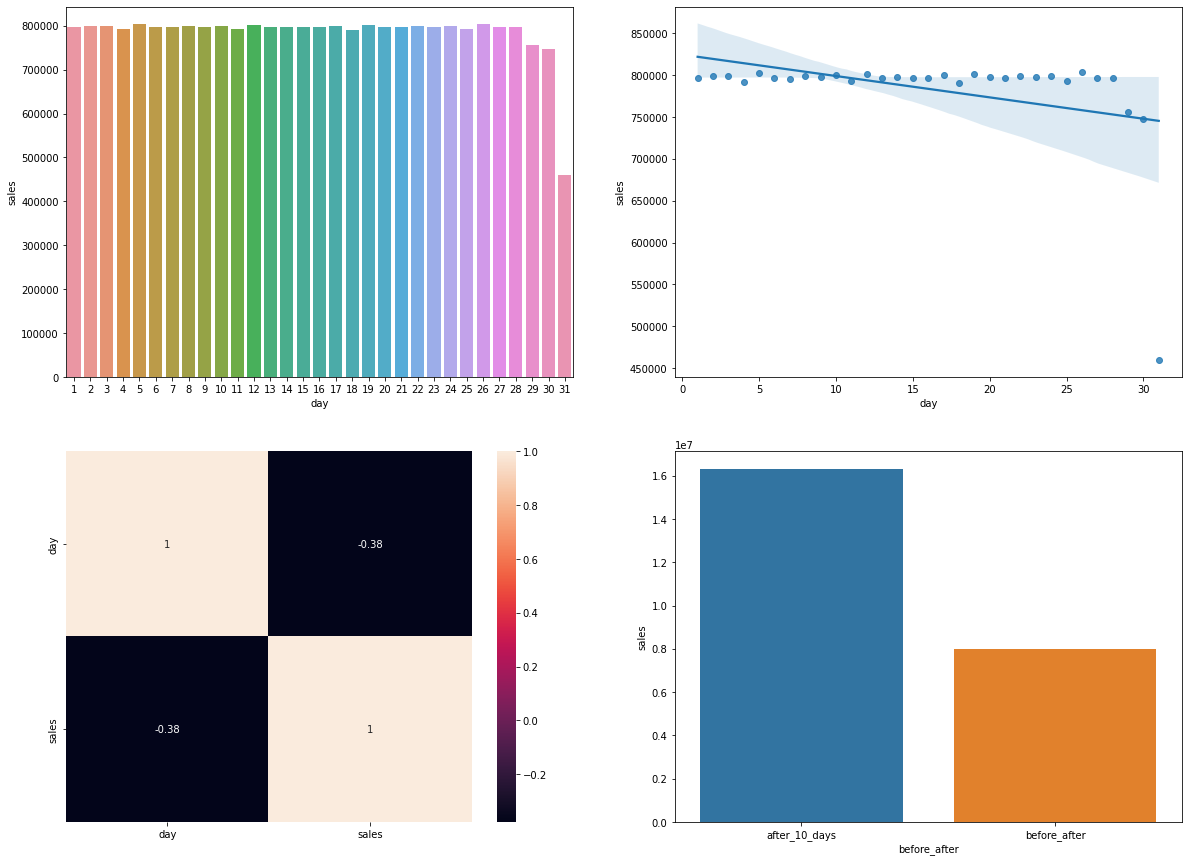

In [53]:
plt.figure(figsize=(20,15)) 
aux1 = df3[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_after' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

*** Stores sell less items on weekends***

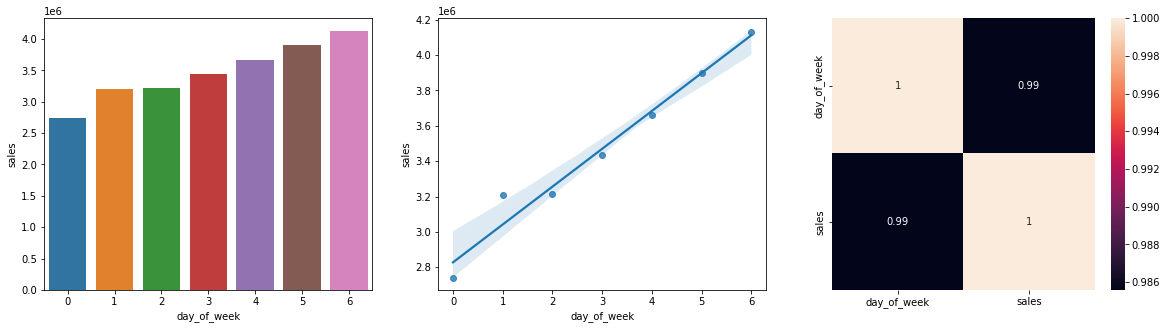

In [54]:
plt.figure(figsize=(20,5)) 
aux1 = df3[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True ); 
# Return the day of the week. It is assumed the week starts on Monday, which is denoted by 0 and ends on Sunday which is denoted by 6.

In [55]:
num_attributes = df1.select_dtypes( include=['int64'] )
num_attributes.sample()

""
244879


**CORRELATION**

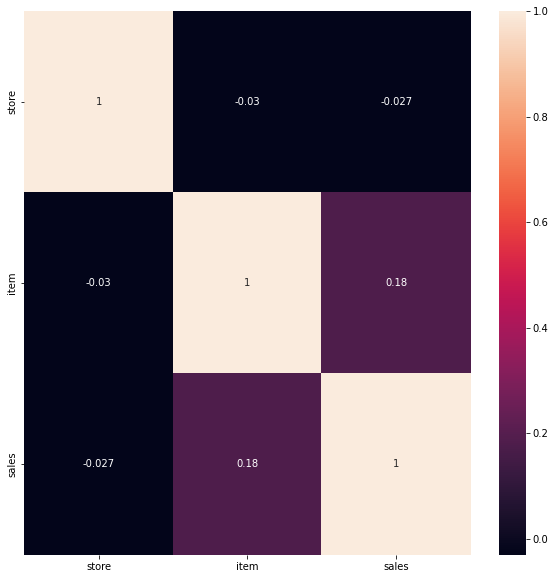

In [56]:
plt.figure(figsize=(10,10)) 
correlation = df1.corr( method='pearson' )
sns.heatmap( correlation, annot=True )

**DATA PREPARATION**

In [57]:
df4 = df3.copy()

In [58]:
df4.head()

,date,store,item,sales,year,month,day,day_of_week,week_of_year,year_week
0,2013-01-01,1.0,1.0,13.0,2013,1,1,1,1,2013-00
1,2013-01-02,1.0,1.0,11.0,2013,1,2,2,1,2013-00
2,2013-01-03,1.0,1.0,14.0,2013,1,3,3,1,2013-00
3,2013-01-04,1.0,1.0,13.0,2013,1,4,4,1,2013-00
4,2013-01-05,1.0,1.0,10.0,2013,1,5,5,1,2013-00


** Rescaling**

In [59]:
# normlize ranage of dataframe 

a = df4.select_dtypes( include=['int64', 'float64'] )

In [60]:
a.sample()

,store,item,sales,year,month,day,day_of_week,week_of_year
184719,2.0,11.0,54.0,2013,10,21,0,43


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


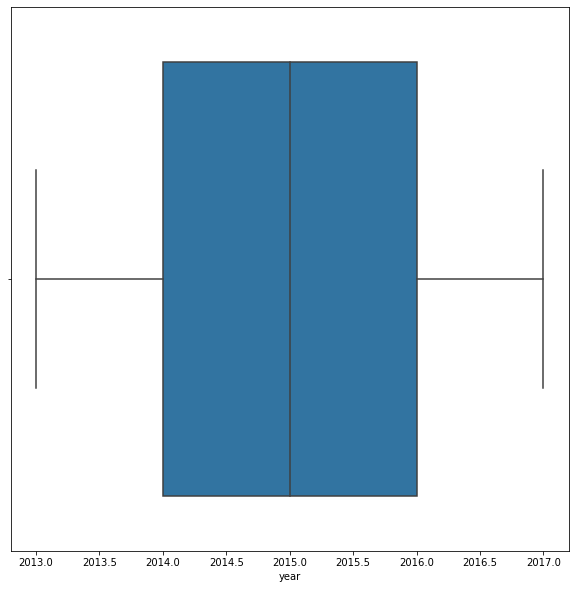

In [61]:
plt.figure(figsize=(10,10)) 
sns.boxplot( df4['year'] )

In [62]:
# response varible transformation 
# statistical assumptions to check the spread of the responses around the model


df4['sales'] = np.log1p( df4['sales'] )

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


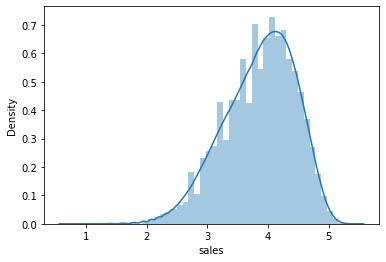

In [63]:
sns.distplot( df4['sales'] )

**Nature Transformation**

In [ ]:
# My goal here is to take the numerical data and transform its natures to cyclical.
# The cyclical variable in this dataset are "day_of_week", "month", "day" and "week of year".


# I am not going to go into mathematical details about the method used to turn numeric or categorical variables into cyclical ones.
# Cyclic behavior looks like a circle. The code will place the values within each variable in this circle.
# Note that at the end of the formula I divide by the amount of cyclic values present in each variable.

In [64]:
# day of week
df4['day_of_week_sin'] = df4['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df4['day_of_week_cos'] = df4['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df4['month_sin'] = df4['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df4['month_cos'] = df4['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df4['day_sin'] = df4['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df4['day_cos'] = df4['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df4['week_of_year_sin'] = df4['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df4['week_of_year_cos'] = df4['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

In [65]:
df4.sample(5)

,date,store,item,sales,year,month,day,day_of_week,week_of_year,year_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
194971,2016-11-16,7.0,11.0,3.951244,2016,11,16,2,46,2016-46,0.974928,-0.222521,-5.000000e-01,8.660254e-01,-0.207912,-0.978148,-0.663123,0.748511
40613,2014-03-18,3.0,3.0,3.526361,2014,3,18,1,12,2014-11,0.781831,0.623490,1.000000e+00,6.123234e-17,-0.587785,-0.809017,0.992709,0.120537
261725,2014-08-31,4.0,15.0,4.691348,2014,8,31,6,35,2014-34,-0.781831,0.623490,-8.660254e-01,-5.000000e-01,0.207912,0.978148,-0.885456,-0.464723
384541,2015-12-18,1.0,22.0,3.951244,2015,12,18,4,51,2015-50,-0.433884,-0.900969,-2.449294e-16,1.000000e+00,-0.587785,-0.809017,-0.120537,0.992709
368995,2013-05-24,3.0,21.0,3.663562,2013,5,24,4,21,2013-20,-0.433884,-0.900969,5.000000e-01,-8.660254e-01,-0.951057,0.309017,0.568065,-0.822984


In [66]:
df5 = df4.copy()
df5.shape

(446070, 18)

**Split dataframe into train and test dataset**

In [67]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'year_week']
df5 = df5.drop( cols_drop, axis=1 )

In [68]:
df5.sample()

,date,store,item,sales,year,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
290993,2014-10-22,10.0,16.0,3.332205,2014,0.974928,-0.222521,-0.866025,0.5,-0.994522,-0.104528,-0.885456,0.464723


In [69]:
df5.shape

(446070, 13)

In [70]:
# As we will predict the next 3 months, I will use the calculation (30*3) to subtract from the max date inside dataset.
df5[['store', 'item', 'date']].groupby( ['store', 'item'] ).max().reset_index()['date'][0] - datetime.timedelta( days=30*3 )

Timestamp('2017-10-02 00:00:00')

In [71]:
# training dataset
X_train = df5[df5['date'] < '2017-10-02']
y_train = X_train['sales']

# test dataset
X_test = df5[df5['date'] >= '2017-10-02']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date']. min() ) )
print( 'Training Max Date: {}'.format( X_train['date']. max() ) )

print( '\nTest Min Date: {}'.format( X_test['date']. min() ) )
print( 'Test Max Date: {}'.format( X_test['date']. max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2017-10-01 00:00:00

Test Min Date: 2017-10-02 00:00:00
Test Max Date: 2017-12-31 00:00:00


In [72]:
X_train.head()

,date,store,item,sales,year,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,2013-01-01,1.0,1.0,2.639057,2013,0.781831,0.623490,0.5,0.866025,0.207912,0.978148,0.120537,0.992709
1,2013-01-02,1.0,1.0,2.484907,2013,0.974928,-0.222521,0.5,0.866025,0.406737,0.913545,0.120537,0.992709
2,2013-01-03,1.0,1.0,2.708050,2013,0.433884,-0.900969,0.5,0.866025,0.587785,0.809017,0.120537,0.992709
3,2013-01-04,1.0,1.0,2.639057,2013,-0.433884,-0.900969,0.5,0.866025,0.743145,0.669131,0.120537,0.992709
4,2013-01-05,1.0,1.0,2.397895,2013,-0.974928,-0.222521,0.5,0.866025,0.866025,0.500000,0.120537,0.992709


In [73]:
y_train, len(y_train)

(0         2.639057
 1         2.484907
 2         2.708050
 3         2.639057
 4         2.397895
             ...   
 446066    4.394449
 446067    4.234107
 446068    4.060443
 446069    4.219508
 446070    4.219508
 Name: sales, Length: 423866, dtype: float64, 423866)

** Boruta as Feature Selector**

In [87]:
!pip install boruta 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 2.7 MB/s 


In [88]:
from boruta import BorutaPy

In [101]:
# training and test dataset for Boruta
X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

# define RandomForestRegression
rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	2


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	2


In [102]:
cols_selected = boruta.support_.tolist()

# best feature
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [103]:
cols_selected_boruta

['store',
 'item',
 'year',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'week_of_year_sin',
 'week_of_year_cos']

In [104]:
cols_not_selected_boruta

['day_cos', 'day_sin']

**Manual** **Feature** **Selection**

In [106]:
#we will add the columns
cols_selected_boruta = [
     'store',
     'item',
     'year',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_sin',
     'month_cos',
     'week_of_year_sin',
     'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [107]:
cols_selected_boruta

['store',
 'item',
 'year',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'week_of_year_sin',
 'week_of_year_cos']

In [108]:
cols_selected_boruta_full

['store',
 'item',
 'year',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

**MACHINE LEARNING MODELLING**

In [109]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparartion
X_training = X_train[ cols_selected_boruta_full ]

In [166]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'item', 'sales']].groupby( ['store', 'item'] ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on=['store', 'item'] )
yhat_baseline = aux1['predictions']

# performance
baseline_result =ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,10.341608,1.870144,13.655757


**Linear Regression Model**

In [167]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result =ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,23.30759,0.507806,29.337986


**Linear Regression Model - Cross Validation**

In [182]:
lr_result_cv = cross_validation( X_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,24.73 +/- 3.3,0.53 +/- 0.02,30.31 +/- 3.82


** Linear Regression Regularized Model**

In [183]:
# model
lrr = Lasso( alpha=0.00001 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,23.3071,0.50782,29.336819


**Linear Regression - Lasso - Cross Validation**

In [184]:
lrr_result_cv = cross_validation( X_training, 5, 'Linear Regression - Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,24.73 +/- 3.3,0.53 +/- 0.02,30.31 +/- 3.82


**Random Forest Regressor**

In [185]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,7.192266,0.145095,9.403282


**Random Forest Regressor - Cross Validation**

In [186]:
rf_result_cv = cross_validation( X_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,7.41 +/- 0.45,0.14 +/- 0.01,9.66 +/- 0.57


**XGBoost Regressor**

In [187]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                             n_estimators=100, 
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6.31416,0.126852,8.266358


**XGBoost Regressor - Cross Validation**

In [188]:
xgb_result_cv = cross_validation( X_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,6.51 +/- 0.4,0.12 +/- 0.01,8.52 +/- 0.52


**Random Search**

In [192]:
param = { 
        'n_estimators': [1500, 1700, 2500, 3000, 3500],
        'eta': [0.01, 0.03],
        'max_depth': [3, 5, 9],
        'subsample': [0.1, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.7, 0.9],
        'min_child_weight': [3, 8, 15] 
        }

MAX_EVAL = 5

In [218]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL):
    #chose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )
    
    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'], 
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'] )

 

{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}


In [ ]:
  # performance
result = cross_validation( X_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
final_result = pd.concat( [final_result, result] )

final_result

**Final Model**

In [194]:
param_tuned = { 
        'n_estimators': 2500,
        'eta': 0.01,
        'max_depth': 3,
        'subsample': 0.7,
        'colsample_bytree': 0.3,
        'min_child_weight': 15
        }

In [195]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                            n_estimators=param_tuned['n_estimators'], 
                            eta=param_tuned['eta'],
                            max_depth=param_tuned['max_depth'],
                            subsample=param_tuned['subsample'],
                            colsample_bytree=param_tuned['colsample_bytree'],
                            min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,5.903115,0.123024,7.661486


In [196]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.008719493899788256

**TRANSLATION AND INTERPRETATION OF THE ERROR**

In [198]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

**Business Performance**

In [200]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAPE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [201]:
# sum of predictions
df93 = df9[['item', 'predictions']].groupby( 'item' ).sum().reset_index()

# MAE e MAPE
df9_aux4 = df9[['item', 'sales', 'predictions']].groupby( 'item' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )
df9_aux5 = df9[['item', 'sales', 'predictions']].groupby( 'item' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

# Merge
df9_aux6 = pd.merge( df9_aux4, df9_aux5, how='inner', on='item' )
df94 = pd.merge( df93, df9_aux6, how='inner', on='item' )

# Scenarios
df94['worst_scenario'] = df94['predictions'] - df94['MAE']
df94['best_scenario'] = df94['predictions'] + df94['MAPE']

# order columns
df94 = df94[['item', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [202]:
df9_aux1.head()

,store,MAE
0,1.0,5.615182
1,2.0,6.676772
2,3.0,6.371884
3,4.0,6.218826
4,5.0,5.175170


In [203]:
df9_aux4.head()

,item,MAE
0,1.0,3.645565
1,2.0,5.980459
2,3.0,5.144157
3,4.0,3.885372
4,5.0,3.467161


In [204]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
6,7.0,84128.554688,84123.717427,84128.700775,4.837260,0.146087
5,6.0,91772.296875,91767.033286,91772.440909,5.263589,0.144034
4,5.0,91931.546875,91926.371705,91931.686854,5.175170,0.139979
0,1.0,116407.359375,116401.744193,116407.487147,5.615182,0.127772
3,4.0,134955.921875,134949.703049,134956.042198,6.218826,0.120323


In [205]:
df94.sort_values( 'MAPE', ascending=False ).head()

,item,predictions,worst_scenario,best_scenario,MAE,MAPE
4,5.0,16913.599609,16910.132449,16913.801051,3.467161,0.201441
3,4.0,20234.748047,20230.862675,20234.932293,3.885372,0.184246
0,1.0,20367.490234,20363.844669,20367.670275,3.645565,0.180041
15,16.0,23907.849609,23903.852583,23908.017440,3.997026,0.167830
22,23.0,27195.726562,27191.089840,27195.891776,4.636723,0.165214


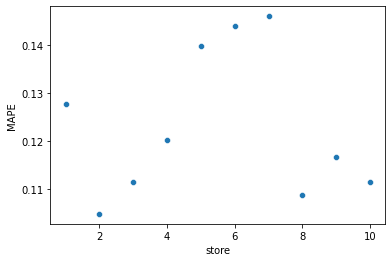

In [206]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

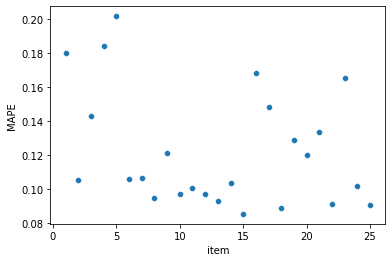

In [207]:
sns.scatterplot( x='item', y='MAPE', data=df94 )

**Total Performance**

In [208]:
df95 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values p Store'} )
df95['Values p Store'] = df95['Values p Store'].map( '{:,.2f} items'.format )
df95

,Scenario,Values p Store
0,predictions,"1,243,673.25 items"
1,worst_scenario,"1,243,614.32 items"
2,best_scenario,"1,243,674.53 items"


In [209]:
df96 = df94[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values p Item'} )
df96['Values p Item'] = df96['Values p Item'].map( '{:,.2f} items'.format )
df96

,Scenario,Values p Item
0,predictions,"1,243,673.38 items"
1,worst_scenario,"1,243,524.45 items"
2,best_scenario,"1,243,676.36 items"


** Machine Learning Performance**

In [212]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

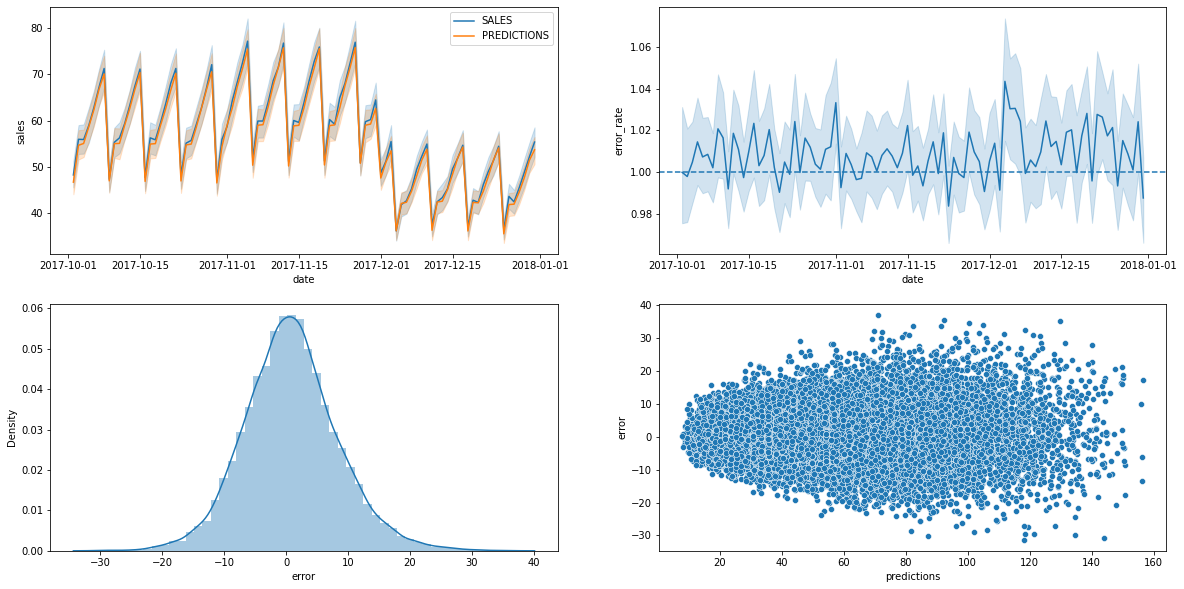

In [215]:
plt.figure(figsize=(20,10))
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--' )

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )